In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [3]:
df =  pd.read_csv('2yrs_data.csv')

In [4]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.sort_values('Datetime')
data = df['Global_active_power'].values.reshape(-1, 1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [6]:
class MultiStepTimeSeriesGenerator():
    """
    Copied and edited from https://www.tensorflow.org/tutorials/structured_data/time_series
    """

    def __init__(self, 
                 input_width, 
                 label_width, 
                 shift,
                 df,
                 batch_size,
                 train_ratio=0.6,
                 val_ratio=0.2):
        
        # Ensure ratios add up to 1
        assert train_ratio + val_ratio < 1.0, "Train and val ratios must sum to less than 1.0 (leave space for test)."
        
        # Work out the window parameters
        self.input_width       = input_width
        self.label_width       = label_width
        self.shift             = shift
        self.batch_size        = batch_size
        self.total_window_size = input_width + label_width
        self.input_slice       = slice(0, input_width)
        self.labels_slice      = slice(self.total_window_size - self.label_width, None)
        
        # Calculate dataset split indices
        total_data = len(df) - (input_width + label_width)
        train_end = int(total_data * train_ratio)
        val_end = train_end + int(total_data * val_ratio)

        # Split the data
        self.train_df = df[:train_end]
        self.val_df = df[train_end:val_end]
        self.test_df = df[val_end:]

        # Create datasets
        self.train = self.make_dataset(self.train_df)
        self.val = self.make_dataset(self.val_df)
        self.test = self.make_dataset(self.test_df)

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        labels = tf.stack([labels[:, :, 0]], axis=-1)
    
        # Slicing doesn't preserve static shape information, so set the shapes manually
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(data=data,
                                                          targets=None,
                                                          sequence_length=self.total_window_size,
                                                          sequence_stride=1,
                                                          shuffle=False,
                                                          batch_size=self.batch_size)

        ds = ds.map(self.split_window)

        return ds

In [7]:
N_STEPS_IN = 24
N_STEPS_OUT = 12
N_EPOCHS = 10   
BATCH_SIZE = 64
time_series_dataset = MultiStepTimeSeriesGenerator(input_width=N_STEPS_IN, 
                                         label_width=N_STEPS_OUT, 
                                         shift=12, 
                                         df=data_scaled, 
                                         batch_size=BATCH_SIZE,
                                         train_ratio=0.6, 
                                         val_ratio=0.2)

# Access datasets
train_data = time_series_dataset.train
val_data = time_series_dataset.val
test_data = time_series_dataset.test

# Print dataset info
print(f"Train size: {len(time_series_dataset.train_df)}")
print(f"Validation size: {len(time_series_dataset.val_df)}")
print(f"Test size: {len(time_series_dataset.test_df)}")

Train size: 642318
Validation size: 214106
Test size: 214142


In [8]:
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(N_STEPS_IN, 1)),
    LSTM(32, activation='relu'),
    Dense(N_STEPS_OUT) 
])

# Compile model
model.compile(loss      = tf.losses.MeanSquaredError(),
              optimizer = tf.optimizers.Adam(),
              metrics   = [tf.metrics.MeanAbsoluteError()])

# Create datasets from dataframe
time_series_dataset = MultiStepTimeSeriesGenerator(input_width=N_STEPS_IN, 
                                         label_width=N_STEPS_OUT, 
                                         shift=12, 
                                         df=data_scaled, 
                                         batch_size=BATCH_SIZE,
                                         train_ratio=0.6, 
                                         val_ratio=0.2)
# Train model
history = model.fit(time_series_dataset.train, 
                    validation_data = time_series_dataset.val,
                    epochs          = N_EPOCHS,
                    verbose         = 1, 
                    callbacks       = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                       patience = 4,
                                                                       restore_best_weights=True),
                    shuffle         = False)

# Evaluate the model on the test set
test_predictions = model.predict(time_series_dataset.test, verbose=0)

# Prepare the test labels
test_labels = np.concatenate(
    [batch[1] for batch in time_series_dataset.test.as_numpy_iterator()], axis=0
)

# Reshape predictions if necessary
test_predictions = np.squeeze(test_predictions)
test_labels = np.squeeze(test_labels)

# Calculate the test Mean Squared Error
test_mse = mean_squared_error(test_labels, test_predictions)
test_mse = np.round(test_mse, 5)

print(f"Test Mean Squared Error: {test_mse}")


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10036/10036 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0390 - val_loss: 0.0029 - val_mean_absolute_error: 0.0285
Epoch 2/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - loss: 0.0034 - mean_absolute_error: 0.0304 - val_loss: 0.0028 - val_mean_absolute_error: 0.0289
Epoch 3/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - loss: 0.0033 - mean_absolute_error: 0.0299 - val_loss: 0.0029 - val_mean_absolute_error: 0.0291
Epoch 4/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 90s 9ms/step - loss: 0.0033 - mean_absolute_error: 0.0296 - val_loss: 0.0029 - val_mean_absolute_error: 0.0294
Epoch 5/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0293 - val_loss: 0.0028 - val_mean_absolute_error: 0.0292
Epoch 6/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step - loss: 0.0032 - mean_absolute_error: 0.0291 - val_loss: 0.0029 - val_mean_absolute_error: 0.0301
Epoch 7/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 107s 11ms/step - loss: 0.0032 - mean

2024-11-25 16:29:41.325682: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
mape = np.mean(np.abs((test_labels - test_predictions) / test_labels)) * 100
print(f"Test MAPE: {mape:.2f}%")

from sklearn.metrics import r2_score
r2 = r2_score(test_labels, test_predictions)
print(f"R² Score: {r2:.5f}")

test_mse = mean_squared_error(test_labels, test_predictions)
print(f"Test MSE: {test_mse:.5f}")

Test MAPE: inf%
R² Score: 0.76534
Test MSE: 0.00235


/var/folders/hb/pn_3c51d1fj1n2jntgjrxmpm0000gn/T/ipykernel_61092/280497842.py:1: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((test_labels - test_predictions) / test_labels)) * 100


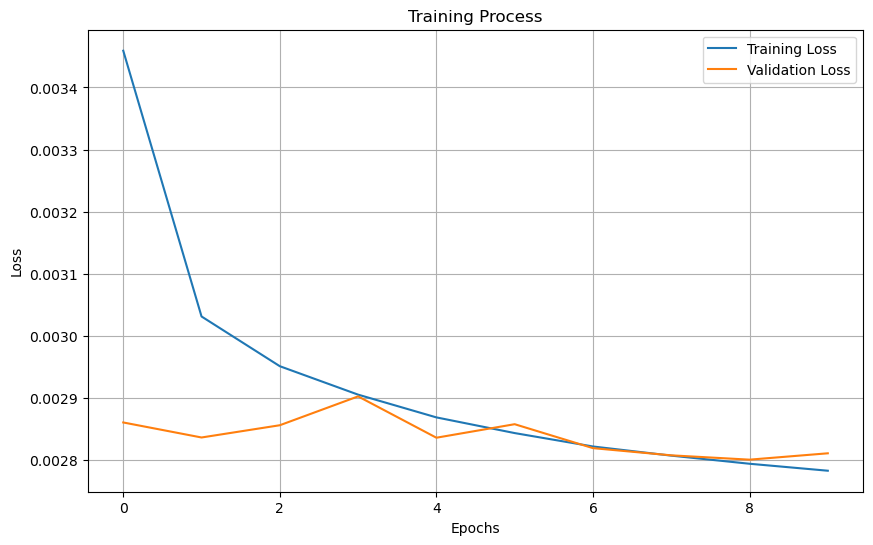

In [9]:
# Extract training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training Process')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
#model.save('lstm_model.pth')

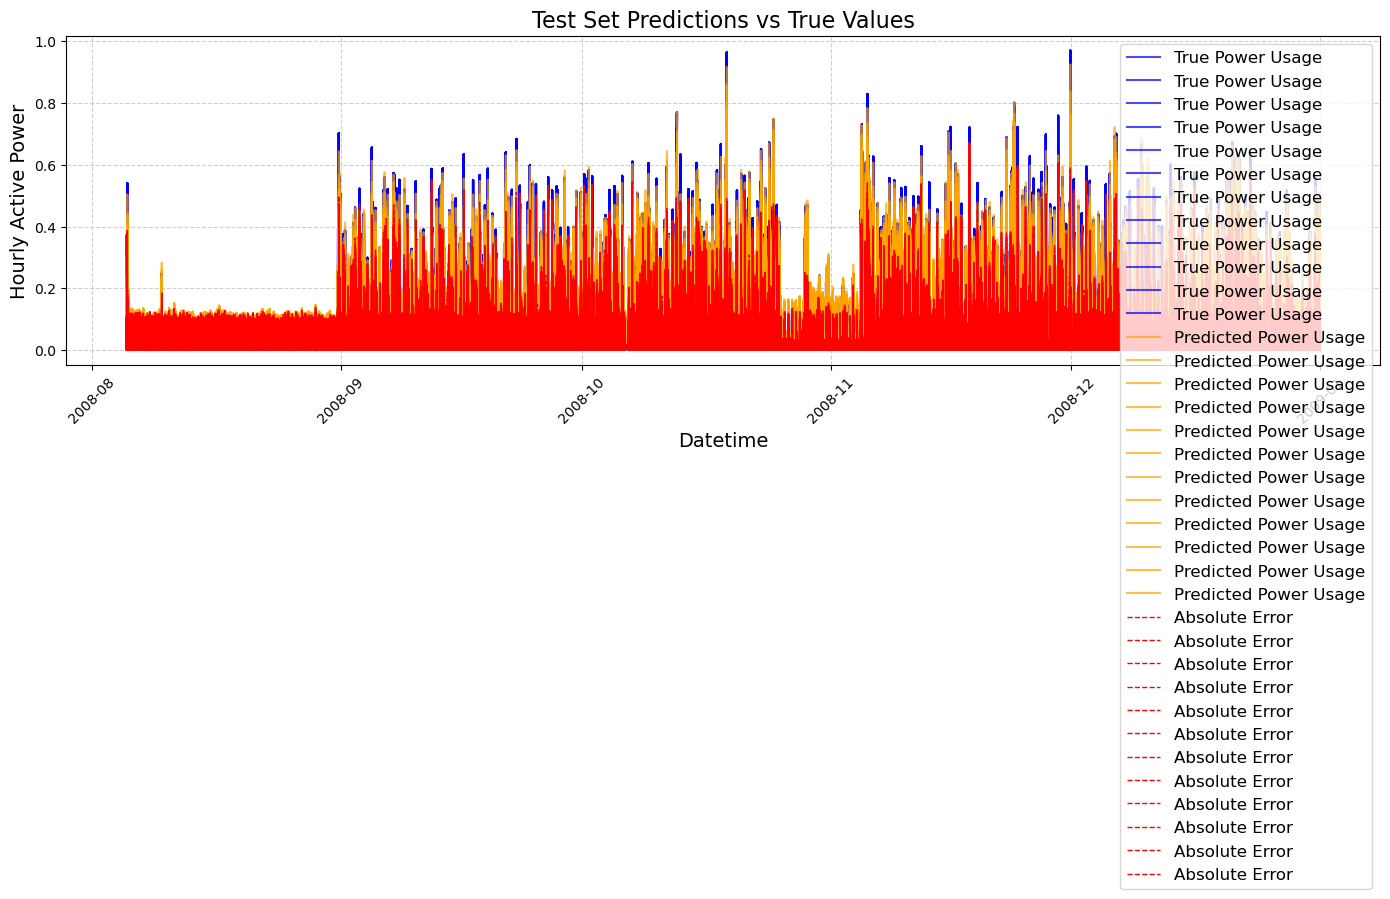

In [22]:
absolute_error = np.abs(test_labels - test_predictions)

datetime_test = df['Datetime'][-len(test_labels):]
plt.figure(figsize=(14, 7))
plt.plot(datetime_test, test_labels, label='True Power Usage', color='blue', linewidth=1.5, alpha=0.7)
plt.plot(datetime_test, test_predictions, label='Predicted Power Usage', color='orange', linewidth=1.5, alpha=0.7)
plt.plot(datetime_test, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1)

# Add labels, title, legend, and grid
plt.title('Test Set Predictions vs True Values', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Hourly Active Power', fontsize=14)
plt.legend(fontsize=12, loc='upper right')  # Ensure a single legend with proper placement
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

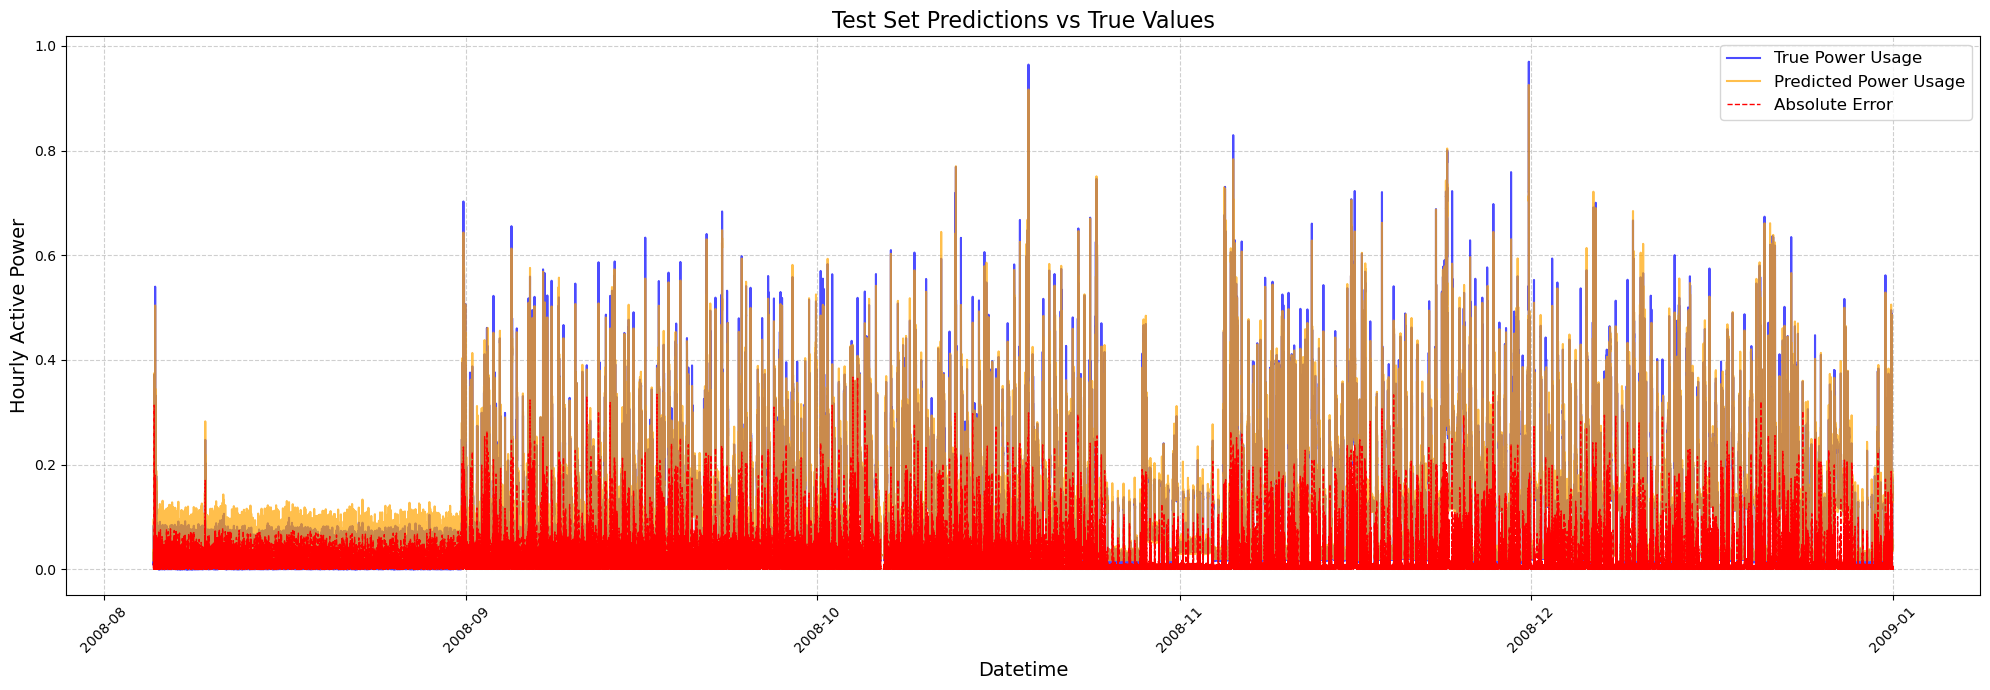

In [20]:
test_labels_1d = test_labels[:, 0]  # Select the first timestep from each sequence
test_predictions_1d = test_predictions[:, 0]

# Assuming test_labels_1d, test_predictions_1d, and datetime_test are defined
absolute_error = np.abs(test_labels_1d - test_predictions_1d)

plt.figure(figsize=(20, 7))

# Plot each data type
line1, = plt.plot(datetime_test, test_labels_1d, label='True Power Usage', color='blue', linewidth=1.5, alpha=0.7)
line2, = plt.plot(datetime_test, test_predictions_1d, label='Predicted Power Usage', color='orange', linewidth=1.5, alpha=0.7)
line3, = plt.plot(datetime_test, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1)

# Add a single legend
plt.legend(handles=[line1, line2, line3], fontsize=12, loc='upper right')

# Add labels, title, and grid
plt.title('Test Set Predictions vs True Values', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Hourly Active Power', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
